# Разработка полностью связанной нейронной сети

<u>Цель </u>получить базовые навыки работы с одной из библиотек глубокого обучения (Caffe, Torch, TensorFlow или MXNet на выбор) на примереполностью связанных нейронных сетей.


  

Для выполнения данной работы мной была выбрана библиотека torch.

Данная работа состоит из частей.
1. <u>Загрузка библиотек </u> В данной части были загружены, а в случае необходмости, установлены необходмые библиотеки. Также зафиксированы рандомные значения, а также технические функции.  
2. <u>Проверка на даных mnist </u> В данной части были закружены данные mnist, создана нейронная сеть соответвующая логистической рересии, проверена работа сети на данных mnist.
3. <u>Подготовка данных </u> Предварительный просмотр данных, их колличества и содержания. Загрузка данных, создание датесета и загрузчика данных. Разработка программ/скриптов для подготовки тренировочных и тестовых данных.
4. <u>Разработка и обучение нейронных сетей</u>
5. <u>Тестирование</u> Проверка работы сетей на тестовых данных.
6. <u>Подбор гиперпараметров</u> Подбор с помощью optuna.
4. <u>Вывод</u>


## Часть 1. Загрузка необходмых библиотек

In [ ]:
# общие библиотеки
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import plotly.offline as pyo
import optuna

# билиотека torch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
def grafic(train_losses, val_losses, val_accuracies):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, len(train_losses) + 1)), y=train_losses,
                         mode='lines+markers', name='Training Loss'))
    fig.add_trace(go.Scatter(x=list(range(1, len(val_losses) + 1)), y=val_losses,
                         mode='lines+markers', name='Validation Loss'))
    fig.add_trace(go.Scatter(x=list(range(1, len(val_accuracies) + 1)), y=val_accuracies,
                         mode='lines+markers', name='Validation Accuracy', yaxis='y2'))

    fig.update_layout(title='Training and Validation Loss/Accuracy',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  yaxis2=dict(title='Accuracy (%)', overlaying='y', side='right'),
                  template='plotly_white')

    pyo.iplot(fig)

## Часть 2. Проверка на данных mnist

In [ ]:
# загружаем данные mnist, преобразуя данные в тензор и нормадизуя их.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.17MB/s]


Количество обучающих изображений: 60000
Количество тестовых изображений: 10000


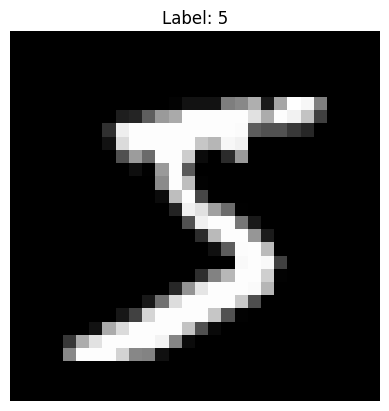

In [ ]:
# проверим, что там загрузилось
print(f'Количество обучающих изображений: {len(train_dataset)}')
print(f'Количество тестовых изображений: {len(test_dataset)}')

image, label = train_dataset[0]
image = image.squeeze().numpy()
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# создаем необходимую нейросеть.
class mnist_pytorch(nn.Module):
    def __init__(self):
        super(mnist_pytorch, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = mnist_pytorch()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# обучаем на 5 эпохах
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# тестируем модель
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy на тестовой выборке: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 0.3007
Epoch [2/5], Loss: 0.2271
Epoch [3/5], Loss: 0.4816
Epoch [4/5], Loss: 0.3047
Epoch [5/5], Loss: 0.1578
Accuracy на тестовой выборке: 91.58%


Точность модели довольно высокая.

## Часть 3. Подготовка данных.

Были использованы данные подмножество набора данных Food-101. Боссард, Лукас, Матье Гийомен и Люк Ван Гул. «Food-101 – Mining Discriminative Components with Random Forests».

Изображения разделены на две папки: pizza  и not_pizza, имеющее равное количество изображений.

Количество изображений в папке: 983


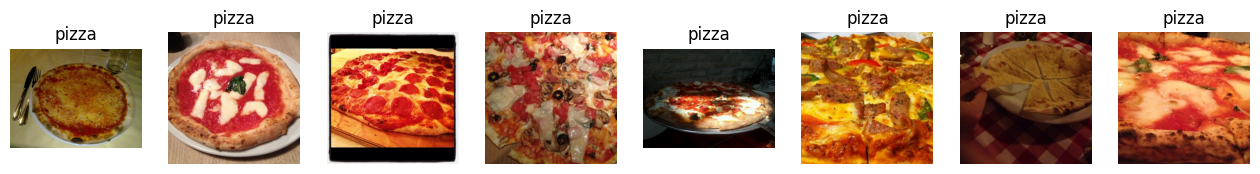

Количество изображений в папке: 983


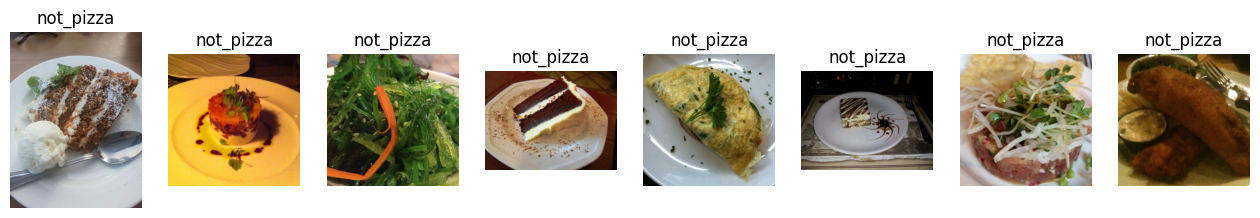

In [ ]:
def display_sample_images(category_name, sample_size=8):

    root_dir = "/content/pizza_not_pizza"
    category_path = os.path.join(root_dir, category_name)
    imgs = random.sample(os.listdir(category_path), sample_size)
    img_paths = [os.path.join(category_path, img) for img in imgs]
    print('Количество изображений в папке:',len(os.listdir(category_path)))

    plt.figure(figsize=(16,4))
    for k in range(sample_size):
        plt.subplot(1, sample_size, k+1)
        img = Image.open(img_paths[k]).convert("RGB")
        plt.imshow(img)
        plt.title(category_name)
        plt.axis("off")
    plt.show()

display_sample_images("pizza")
display_sample_images("not_pizza")

По 983 изображения в каждой папке. Изображения имеют разный размер. Содержание папок соответствует их названию. Изображений довльно мало, плюс ограничены ресурсы для обучеения, поэтому аугментация и увеличение выборки произведены не были.   

In [ ]:
# Загружаем данные и создаем датасет
data_dir = '/content/pizza_not_pizza'
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Определение размеров выборок
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

print(f'Количество обучающих изображений: {train_size}')
print(f'Количество валидационных изображений: {val_size}')
print(f'Количество тестовых изображений: {test_size}')

# Разделение на train, val и test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Предобработка
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# создание загрузчиков
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Количество обучающих изображений: 1376
Количество валидационных изображений: 294
Количество тестовых изображений: 296


## Часть 4. Разработка архитектур нейронных сетей и обучение их.

Создадим три модели, с разным количеством слоев и функциями активации скрытых слоев. Общее в моделях то, что все они являются полносвязными, так как нам нужна бинарная классификация, фактивация последнего слоя - sigmoid
1. Простая модель. Один скрытый линейный слой, функция активации скрытого слоя - RELU.
2. Средняя модель. Четыре скрытых слоя, функция активации скрытого слоя - тангенс.
3. Сложная модель.Четыре скрытых слоя, используем нормализацию, обнуление нейронов и LeakyReLU в качестве активации.



In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(512 * 512 * 3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(512 * 512 * 3, 512)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

In [ ]:
class ReducedNN(nn.Module):
    def __init__(self):
        super(ReducedNN, self).__init__()
        self.fc1 = nn.Linear(512 * 512 * 3, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

Напишем функции, производящие обучение и тестирование на валидационной выборке

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        val_loss, accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()

            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.float()).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return val_loss, accuracy

In [ ]:
# определяем необходмые гиперпараметры, функцию потерь
learning_rate = 0.0001
criterion = nn.BCELoss()
num_epoch = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Инициализация моделей
models = {
    "simple": SimpleNN().to(device),
    "deep": ReducedNN().to(device),
    "complex": ComplexNN().to(device)
}

In [ ]:
optimizer = optim.Adam(models['simple'].parameters(), lr=learning_rate)
train_losses, val_losses, val_accuracies = train_model(models['simple'], train_loader, val_loader, criterion, optimizer, num_epochs=num_epoch)

Epoch [1/30], Loss: 34.9576
Validation Loss: 36.6796, Accuracy: 57.48%
Epoch [2/30], Loss: 34.5469
Validation Loss: 34.4898, Accuracy: 62.24%
Epoch [3/30], Loss: 34.9841
Validation Loss: 32.7212, Accuracy: 65.31%
Epoch [4/30], Loss: 33.3109
Validation Loss: 31.3784, Accuracy: 66.33%
Epoch [5/30], Loss: 34.2447
Validation Loss: 34.6947, Accuracy: 63.27%
Epoch [6/30], Loss: 34.9331
Validation Loss: 33.7927, Accuracy: 65.99%
Epoch [7/30], Loss: 33.4046
Validation Loss: 33.0605, Accuracy: 65.65%
Epoch [8/30], Loss: 31.3397
Validation Loss: 31.7203, Accuracy: 66.67%
Epoch [9/30], Loss: 33.1346
Validation Loss: 32.1887, Accuracy: 67.69%
Epoch [10/30], Loss: 33.7377
Validation Loss: 35.6874, Accuracy: 62.93%
Epoch [11/30], Loss: 33.7577
Validation Loss: 36.4380, Accuracy: 63.61%
Epoch [12/30], Loss: 30.8942
Validation Loss: 30.8565, Accuracy: 68.37%
Epoch [13/30], Loss: 33.2130
Validation Loss: 32.3316, Accuracy: 67.35%
Epoch [14/30], Loss: 32.7587
Validation Loss: 36.3521, Accuracy: 63.27%
E

In [ ]:
grafic(train_losses, val_losses, val_accuracies)

После обучения первой, самой легкой модели какой-то динамики не видно. Модель не может определить веса, не обучается.  

In [ ]:
optimizer = optim.Adam(models['complex'].parameters(), lr=learning_rate)
train_losses, val_losses, val_accuracies = train_model(models['complex'], train_loader, val_loader, criterion, optimizer, num_epochs=num_epoch)

Epoch [1/30], Loss: 0.6570
Validation Loss: 0.6200, Accuracy: 67.69%
Epoch [2/30], Loss: 0.6214
Validation Loss: 0.6220, Accuracy: 67.69%
Epoch [3/30], Loss: 0.6105
Validation Loss: 0.6056, Accuracy: 70.75%
Epoch [4/30], Loss: 0.5909
Validation Loss: 0.5984, Accuracy: 70.41%
Epoch [5/30], Loss: 0.5837
Validation Loss: 0.6413, Accuracy: 65.31%
Epoch [6/30], Loss: 0.5781
Validation Loss: 0.6061, Accuracy: 72.45%
Epoch [7/30], Loss: 0.5655
Validation Loss: 0.6012, Accuracy: 71.09%
Epoch [8/30], Loss: 0.5613
Validation Loss: 0.6126, Accuracy: 69.73%
Epoch [9/30], Loss: 0.5552
Validation Loss: 0.6139, Accuracy: 70.41%
Epoch [10/30], Loss: 0.5521
Validation Loss: 0.6382, Accuracy: 66.33%
Epoch [11/30], Loss: 0.5394
Validation Loss: 0.6702, Accuracy: 63.95%
Epoch [12/30], Loss: 0.5351
Validation Loss: 0.6035, Accuracy: 68.37%
Epoch [13/30], Loss: 0.5335
Validation Loss: 0.6255, Accuracy: 66.67%
Epoch [14/30], Loss: 0.5305
Validation Loss: 0.6329, Accuracy: 68.37%
Epoch [15/30], Loss: 0.5205
V

In [ ]:
grafic(train_losses, val_losses, val_accuracies)

Вторая модель обучается, но уже с 3-4 эпохи возникает переобучение, что влияет на метрику на валидационных данных.

In [ ]:
optimizer = optim.Adam(models['deep'].parameters(), lr=learning_rate)

def he_initialization(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # Для равномерного распределения
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)  # Инициализация смещения нулями

models['deep'].apply(he_initialization)
train_losses, val_losses, val_accuracies = train_model(models['deep'], train_loader, val_loader, criterion, optimizer, num_epochs=num_epoch)

Epoch [1/30], Loss: 0.6985
Validation Loss: 0.5898, Accuracy: 67.69%
Epoch [2/30], Loss: 0.6474
Validation Loss: 0.5967, Accuracy: 69.39%
Epoch [3/30], Loss: 0.6119
Validation Loss: 0.5874, Accuracy: 73.81%
Epoch [4/30], Loss: 0.5957
Validation Loss: 0.5739, Accuracy: 72.11%
Epoch [5/30], Loss: 0.5670
Validation Loss: 0.5836, Accuracy: 71.43%
Epoch [6/30], Loss: 0.5510
Validation Loss: 0.5812, Accuracy: 69.73%
Epoch [7/30], Loss: 0.5384
Validation Loss: 0.5787, Accuracy: 70.41%
Epoch [8/30], Loss: 0.5208
Validation Loss: 0.5787, Accuracy: 70.75%
Epoch [9/30], Loss: 0.5039
Validation Loss: 0.6061, Accuracy: 71.43%
Epoch [10/30], Loss: 0.4864
Validation Loss: 0.5862, Accuracy: 70.75%
Epoch [11/30], Loss: 0.4502
Validation Loss: 0.6008, Accuracy: 71.09%
Epoch [12/30], Loss: 0.4446
Validation Loss: 0.5938, Accuracy: 70.75%
Epoch [13/30], Loss: 0.4358
Validation Loss: 0.5987, Accuracy: 70.07%
Epoch [14/30], Loss: 0.4038
Validation Loss: 0.6344, Accuracy: 69.73%
Epoch [15/30], Loss: 0.4004
V

In [ ]:
grafic(train_losses, val_losses, val_accuracies)

Третья модель показывает лучшую метрику, но также переобучается.

##Часть 5. Тестирочение моделей

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.float()).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
print(f'Accuracy на слабой модели: {test_model(models["simple"], test_loader):.2f}%')
print(f'Accuracy на средней модели: {test_model(models["complex"], test_loader):.2f}%')
print(f'Accuracy на сильной модели: {test_model(models["deep"], test_loader):.2f}%')

Accuracy на слабой модели: 62.50%
Accuracy на средней модели: 65.54%
Accuracy на сильной модели: 70.27%


<u>Вывод</u> Лучший результат на самой сложной модели. На обучение влияет как количество эпох, так и нормализация данных и функция активации.

Дальнейшее усложнение модели приводит к увеличению веса модели, увеличению ресурсов, необходмых для обучения модели. Так как мы рассматриваем изображение, улучшение модели может идти в сторону отхода от идеи полносвязной, использования сверточных слоев.  

## Часть 6. Подбор гиперпараметров

Попробуем программно подобрать гиперпараметры к лучшей сети с помощью библиотеки optuna.

In [ ]:
# строим сеть с возможностью подставления гиперпараметров
class ReducedNN(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super(ReducedNN, self).__init__()
        self.fc1 = nn.Linear(512 * 512 * 3, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

In [ ]:
# подбор гиперпараметров
def train_and_evaluate_model(trial, train_loader, val_loader):

    hidden_size1 = trial.suggest_int("hidden_size1", 128, 512)
    hidden_size2 = trial.suggest_int("hidden_size2", 64, 256)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.001, log=True)
    num_epochs = 5

    model = ReducedNN(hidden_size1, hidden_size2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Обучение
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.float().unsqueeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Оценка
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            targets = targets.float().unsqueeze(1)
            correct += (predicted.flatten() == targets.flatten()).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

# Optuna
def optimize_hyperparameters(train_loader, val_loader):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: train_and_evaluate_model(trial, train_loader, val_loader), n_trials=30)

    print("Best hyperparameters: ", study.best_params)
    print("Best accuracy: ", study.best_value)


optimize_hyperparameters(train_loader, val_loader)

[I 2025-03-16 11:27:34,052] A new study created in memory with name: no-name-5f1253e7-b37d-473f-aa29-af605c097263
[I 2025-03-16 11:28:38,918] Trial 0 finished with value: 0.6462585034013606 and parameters: {'hidden_size1': 211, 'hidden_size2': 129, 'learning_rate': 0.00011971705550723908}. Best is trial 0 with value: 0.6462585034013606.
[I 2025-03-16 11:29:44,283] Trial 1 finished with value: 0.6462585034013606 and parameters: {'hidden_size1': 313, 'hidden_size2': 74, 'learning_rate': 0.0009344898751919742}. Best is trial 0 with value: 0.6462585034013606.
[I 2025-03-16 11:30:55,338] Trial 2 finished with value: 0.6836734693877551 and parameters: {'hidden_size1': 473, 'hidden_size2': 122, 'learning_rate': 0.00035623979764057165}. Best is trial 2 with value: 0.6836734693877551.
[I 2025-03-16 11:32:02,428] Trial 3 finished with value: 0.6496598639455783 and parameters: {'hidden_size1': 437, 'hidden_size2': 82, 'learning_rate': 0.0006097972981553774}. Best is trial 2 with value: 0.68367346

Best hyperparameters:  {'hidden_size1': 455, 'hidden_size2': 65, 'learning_rate': 0.0007459652768356}
Best accuracy:  0.6904761904761905


In [ ]:
# используем полученные гиперпараматры
model = ReducedNN(455, 65).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0007459652768356)
criterion = nn.BCELoss()

def he_initialization(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

model.apply(he_initialization)
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch [1/15], Loss: 0.7259
Validation Loss: 0.6225, Accuracy: 64.97%
Epoch [2/15], Loss: 0.6650
Validation Loss: 0.5983, Accuracy: 65.99%
Epoch [3/15], Loss: 0.6342
Validation Loss: 0.6014, Accuracy: 68.37%
Epoch [4/15], Loss: 0.5961
Validation Loss: 0.5954, Accuracy: 64.63%
Epoch [5/15], Loss: 0.6040
Validation Loss: 0.5905, Accuracy: 68.03%
Epoch [6/15], Loss: 0.5747
Validation Loss: 0.5822, Accuracy: 69.39%
Epoch [7/15], Loss: 0.5622
Validation Loss: 0.5863, Accuracy: 68.37%
Epoch [8/15], Loss: 0.5244
Validation Loss: 0.5831, Accuracy: 68.37%
Epoch [9/15], Loss: 0.5086
Validation Loss: 0.6042, Accuracy: 67.01%
Epoch [10/15], Loss: 0.4808
Validation Loss: 0.5965, Accuracy: 68.71%
Epoch [11/15], Loss: 0.4450
Validation Loss: 0.5992, Accuracy: 70.07%
Epoch [12/15], Loss: 0.4464
Validation Loss: 0.5996, Accuracy: 68.71%
Epoch [13/15], Loss: 0.4288
Validation Loss: 0.6068, Accuracy: 69.73%
Epoch [14/15], Loss: 0.4106
Validation Loss: 0.6413, Accuracy: 66.67%
Epoch [15/15], Loss: 0.3519
V

In [ ]:
grafic(train_losses, val_losses, val_accuracies)

Начиная с 6 эпохи происходит снова переобучение. Попробуем обучить модель на 6 эпохах.

In [ ]:
model = ReducedNN(455, 65).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0007459652768356)
criterion = nn.BCELoss()

def he_initialization(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # Для равномерного распределения
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)  # Инициализация смещения нулями

model.apply(he_initialization)
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=6)

Epoch [1/6], Loss: 0.7025
Validation Loss: 0.6379, Accuracy: 64.97%
Epoch [2/6], Loss: 0.6548
Validation Loss: 0.6172, Accuracy: 66.33%
Epoch [3/6], Loss: 0.6215
Validation Loss: 0.5982, Accuracy: 66.33%
Epoch [4/6], Loss: 0.6279
Validation Loss: 0.5996, Accuracy: 67.01%
Epoch [5/6], Loss: 0.6097
Validation Loss: 0.5952, Accuracy: 64.97%
Epoch [6/6], Loss: 0.5769
Validation Loss: 0.5997, Accuracy: 65.99%


In [ ]:
grafic(train_losses, val_losses, val_accuracies)

In [ ]:
# протестиркуем результат
test_model(model, test_loader)

65.20270270270271

Модель сильно переобучается, из-за этого метрика стала только хуже. Подбор гиперпараметров не улучшает модель, а помогает ей переобучиться.

##Вывод

В данной работе были проведены эксперименты по сознанию полносвязной нейронной сети. В ходе работы было созданы три модели, имебщие различное количество слоев, различные функции активатии.

В ходе тестирования лучше оказалась самая сложная модель. Модель имеет четыре скрытых слоя, нормализацию, обнуление нейронов и LeakyReLU в качестве активации. Результат работы модели на тествых данных (accuracy) - 70,27%.

Проект показал, что использование только полносвязных нейронных сетей для работы с изображениями требует больших вычислительных ресурсов. Чем сложнее модель, тем лучше результат. Да даже в этом соучае результат не показывает высокие метрики. Для работы и изображением нужныф иные подходы, в том числе срерточные слои.   